In [1]:
import fbprophet 
import pandas as pd 
import numpy as np
import sklearn
import seaborn as sns
from fbprophet import Prophet
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

from fbprophet.diagnostics import cross_validation
#import plotly.express as px
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
#import plotly.graph_objects as go
print('Prophet %s' % fbprophet.__version__)
#from matplotlib import pyplot
#import pyodbc as odbc
#import teradata

Prophet 0.6


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    return 100 / len_ * np.nansum(tmp)
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse
def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))
def median_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred)))

In [3]:
df = pd.read_excel ('RECEPCION.xlsX',header=0)
bf = pd.read_excel ('C:/Machine Learning/Prophetbf.xlsx',header=0)

In [4]:
df1=df[df.Tienda==7460]
df1= df1.loc[0:,['Received Date','QTY_received']]
df1=df1.sort_values(['Received Date'], ascending=True)
df1.columns = ['ds', 'y']
df1['ds']= pd.to_datetime(df1['ds'])

df1["Date"] = df1["ds"]
df1.set_index("ds", inplace=True)

bf2 = bf[["ds", "holiday"]]

bf2.set_index("ds", inplace=True)
dummy_holidays = pd.get_dummies(bf2["holiday"], prefix = "holiday")

dummy_holidays.sort_index(inplace=True)
dummy_holidays.head()

df2 = pd.concat([df1, dummy_holidays], axis = 1)

df3 = df2.asfreq("D")

df3.fillna(value = 0, inplace = True)
df3.drop(columns = "Date", inplace = True)

df3["Dia de semana"] = df3.index.day_name()
df3["Media"] = df3["y"].mean()
df3["rolling30"] = df3["y"].rolling(30).mean()

dummy_semana = pd.get_dummies(df3["Dia de semana"],dtype=float)

df4 = pd.concat([df3,dummy_semana], axis = 1)
df4.drop(columns="Monday",inplace=True)
df4.columns = df4.columns.str.replace(" ","")

df4["Dummy_tiempo"] = np.arange(0,len(df4["y"]),1)


train = df4["2018-01-23":"2020-10-23"]
test = df4["2020-10-24":]

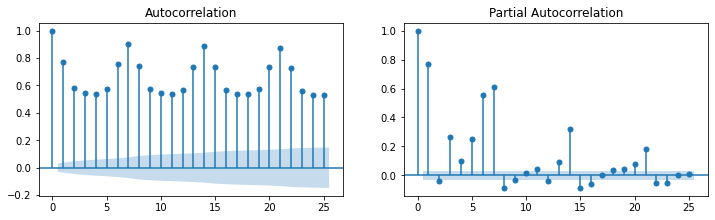

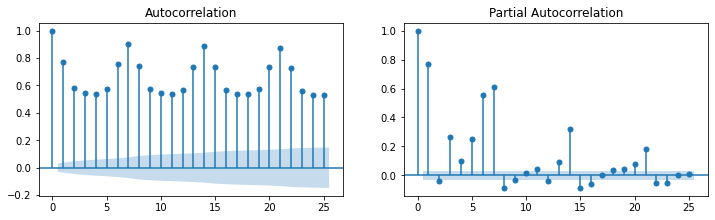

In [5]:
with plt.style.context(style="bmh"):    
        fig = plt.figure(figsize=(12,7))
        layout = (2, 2)

acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))



plot_acf(df4["y"], lags=25, ax=acf_ax)
plot_pacf(df4["y"], lags=25, ax=pacf_ax)

In [6]:
df4["shift1"] = df4["y"].shift(periods=1)
df4["shift2"] = df4["y"].shift(periods=2)
df4["shift3"] = df4["y"].shift(periods=3)
df4["shift4"] = df4["y"].shift(periods=4)
df4["shift5"] = df4["y"].shift(periods=5)
df4["shift6"] = df4["y"].shift(periods=6)
df4["shift7"] = df4["y"].shift(periods=7)
df4["shift8"] = df4["y"].shift(periods=8)
df4["shift9"] = df4["y"].shift(periods=9)

In [7]:
df5= df4.dropna(subset=["shift9"])
df5["Dummy_tiempo"] = np.arange(0,len(df5["y"]),1)

train2 = df5["2018-02-01":"2020-10-23"]
test2 = df5["2020-10-24":]

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

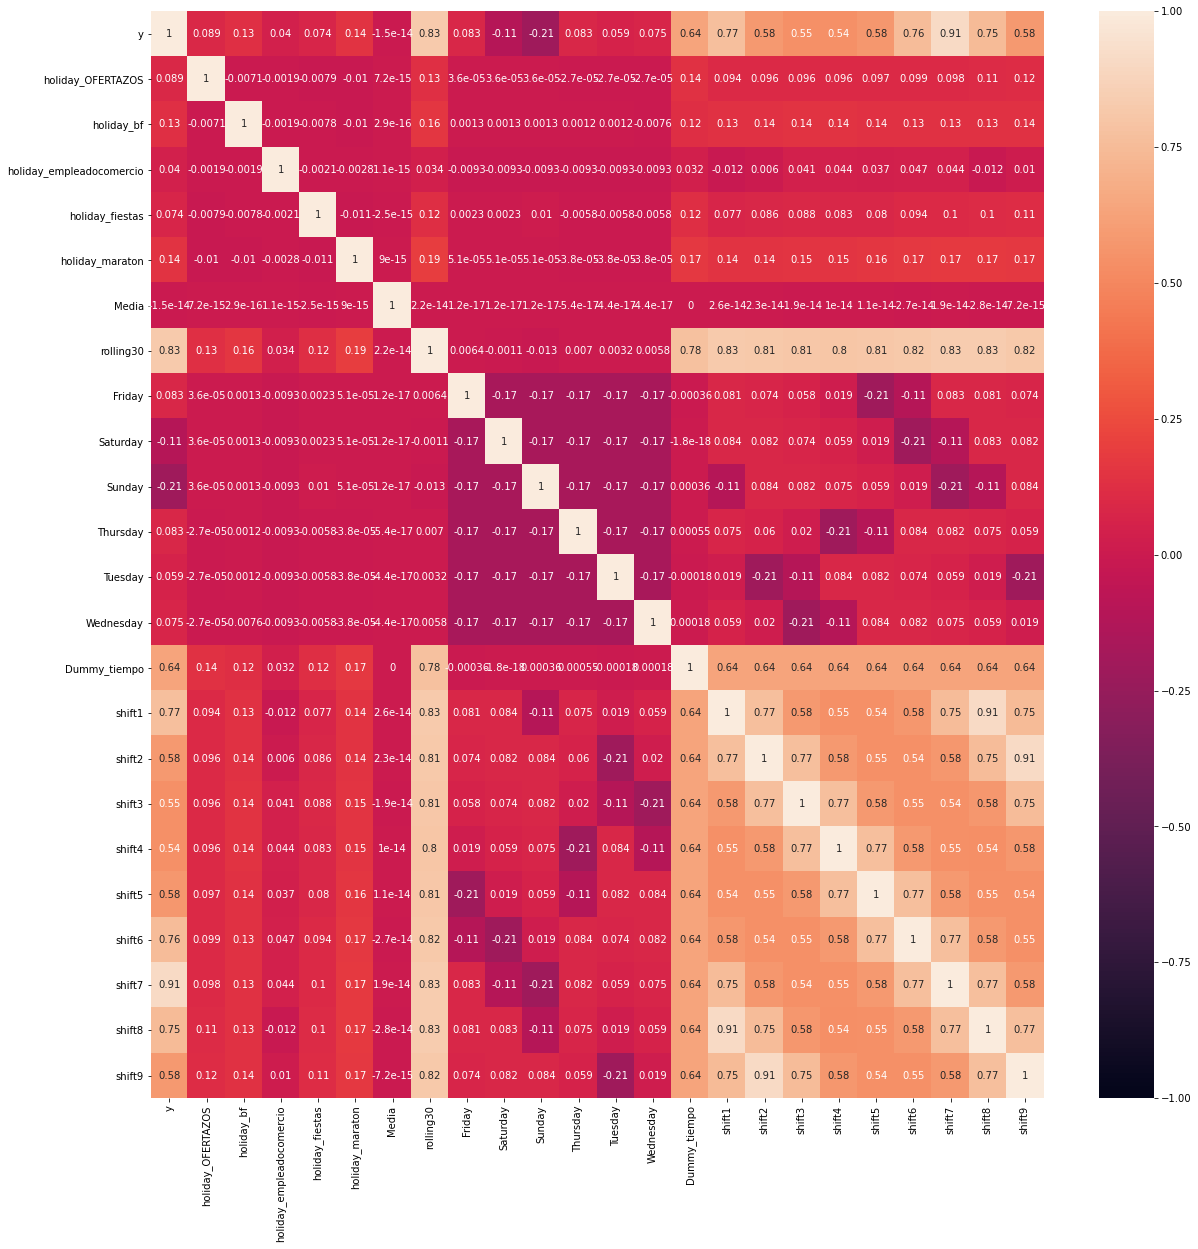

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(df5.corr(), vmin=-1, vmax=1, annot=True)

In [9]:
model_inicial = smf.ols('y ~ Dummy_tiempo + holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday',\
                          data = train).fit()
model_inicial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     171.9
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          4.75e-221
Time:                        18:40:10   Log-Likelihood:                -12078.
No. Observations:                1005   AIC:                         2.418e+04
Df Residuals:                     993   BIC:                         2.424e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 7.842e+04   1.49e+04      5.279      0.000    4.93e+04    1.08e+05
Dummy_tiempo                12.3178      4.477      2.751      0.006       3.531      21.104
holiday_OFERTAZOS         -1.73e+04   1.11e+04     -1.565      0.118    -3.9e+04    4390.669
holiday_bf                3.029e+04   1.13e+04      2.685      0.007    8150.846    5.24e+04
holiday_empleadocomercio  1.936e+04   2.87e+04      0.673      0.501    -3.7e+04    7.58e+04
holiday_fiestas           -2.84e+04   8702.222     -3.263      0.001   -4.55e+04   -1.13e+04
Friday                    3.565e+04   4777.137      7.463      0.000    2.63e+04     4.5e+04
Saturday                  -6.63e+04   4785.376    -13.855      0.000   -7.57e+04   -5.69e+04
Sunday                   -1.169e+05   4785.387    -24.420      0.000   -1.26e+05   -1.07e+05
Thursday                  3.384e+04   4776.791      7.084      0.000    2.45e+04    4.32e+04
Tuesday                   1.924e+04   4777.201      4.027      0.000    9861.173    2.86e+04
Wednesday                 2.902e+04   4777.942      6.073      0.000    1.96e+04    3.84e+04
==============================================================================
Omnibus:                      303.726   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              982.301
Skew:                          -1.471   Prob(JB):                    4.97e-214
Kurtosis:                       6.848   Cond. No.                     7.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:

y_train=train['y']
x_train= train.drop('y',axis=1)
#x_train=np.float64(x_train)
x_train.Tuesday.value_counts()
x_train = x_train.drop('Diadesemana',axis=1)
x_train

holiday_OFERTAZOS  holiday_bf  holiday_empleadocomercio  \
ds                                                                    
2018-01-23                0.0         0.0                       0.0   
2018-01-24                0.0         0.0                       0.0   
2018-01-25                0.0         0.0                       0.0   
2018-01-26                0.0         0.0                       0.0   
2018-01-27                0.0         0.0                       0.0   
...                       ...         ...                       ...   
2020-10-19                0.0         0.0                       0.0   
2020-10-20                0.0         0.0                       0.0   
2020-10-21                0.0         0.0                       0.0   
2020-10-22                0.0         0.0                       0.0   
2020-10-23                0.0         0.0                       0.0   

            holiday_fiestas  holiday_maraton        Media      rolling30  \
ds                                                                         
2018-01-23              0.0              0.0  32280.55587       0.000000   
2018-01-24              0.0              0.0  32280.55587       0.000000   
2018-01-25              0.0              0.0  32280.55587      11.200000   
2018-01-26              0.0              0.0  32280.55587      11.200000   
2018-01-27              0.0              0.0  32280.55587      11.200000   
...                     ...              ...          ...            ...   
2020-10-19              0.0              0.0  32280.55587  111327.066667   
2020-10-20              0.0              0.0  32280.55587  117006.600000   
2020-10-21              0.0              0.0  32280.55587  117251.033333   
2020-10-22              0.0              0.0  32280.55587  116698.266667   
2020-10-23              0.0              0.0  32280.55587  117831.333333   

            Friday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
ds                                                                   
2018-01-23     0.0       0.0     0.0       0.0      1.0        0.0   
2018-01-24     0.0       0.0     0.0       0.0      0.0        1.0   
2018-01-25     0.0       0.0     0.0       1.0      0.0        0.0   
2018-01-26     1.0       0.0     0.0       0.0      0.0        0.0   
2018-01-27     0.0       1.0     0.0       0.0      0.0        0.0   
...            ...       ...     ...       ...      ...        ...   
2020-10-19     0.0       0.0     0.0       0.0      0.0        0.0   
2020-10-20     0.0       0.0     0.0       0.0      1.0        0.0   
2020-10-21     0.0       0.0     0.0       0.0      0.0        1.0   
2020-10-22     0.0       0.0     0.0       1.0      0.0        0.0   
2020-10-23     1.0       0.0     0.0       0.0      0.0        0.0   

            Dummy_tiempo  
ds                        
2018-01-23          2740  
2018-01-24          2741  
2018-01-25          2742  
2018-01-26          2743  
2018-01-27          2744  
...                  ...  
2020-10-19          3740  
2020-10-20          3741  
2020-10-21          3742  
2020-10-22          3743  
2020-10-23          3744  

[1005 rows x 14 columns]

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
    
#Hyperparameter Tuning and Cross Validation
parameters = {
        "loss":["quantile"],
        "alpha":[0.5],
        "max_depth":[5],
        "n_estimators":[250],        
        "learning_rate":[0.01,0.05, 0.1],
        "min_samples_split":[9],
        "min_samples_leaf":[9]
        }
xgb = GridSearchCV(GradientBoostingRegressor(), parameters, n_jobs = 1, pre_dispatch = 24, cv = 3)
xgb.fit(x_train, y_train)
y_pred=xgb.predict(test.drop(['y','Diadesemana'],axis=1))
#mean_absolute_percentage_error(test.y,y_pred)

test.y
y_pred.sum()


#A=pd.concat([pd.DataFrame.reset_index(pd.DataFrame(test.y)),pd.DataFrame.reset_index(pd.DataFrame(y_pred))])


16290226.930566195

In [13]:
#test=pd.DataFrame(test).reset_index(drop=True, inplace=True)
#test=pd.DataFrame(test)
test.reset_index(drop=True,inplace=True)
test.y
y_pred=pd.DataFrame(y_pred)
y_pred.reset_index(drop=True,inplace=True)
A=pd.concat([pd.DataFrame(test.y),pd.DataFrame(y_pred)],axis=1)
A.columns=["y_true","y_pred"]


In [14]:
model_inicial2 = smf.ols('y ~ holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday',\
                          data = train).fit()
model_inicial2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     187.1
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          1.44e-220
Time:                        18:40:46   Log-Likelihood:                -12081.
No. Observations:                1005   AIC:                         2.418e+04
Df Residuals:                     994   BIC:                         2.424e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.182e+05   3419.330     34.568      0.000    1.11e+05    1.25e+05
holiday_OFERTAZOS        -1.153e+04   1.09e+04     -1.059      0.290   -3.29e+04    9835.288
holiday_bf                3.226e+04   1.13e+04      2.856      0.004    1.01e+04    5.44e+04
holiday_empleadocomercio   2.31e+04   2.88e+04      0.802      0.423   -3.34e+04    7.96e+04
holiday_fiestas          -2.807e+04   8730.131     -3.216      0.001   -4.52e+04   -1.09e+04
Friday                    3.571e+04   4792.850      7.450      0.000    2.63e+04    4.51e+04
Saturday                 -6.627e+04   4801.152    -13.804      0.000   -7.57e+04   -5.69e+04
Sunday                   -1.168e+05   4801.152    -24.332      0.000   -1.26e+05   -1.07e+05
Thursday                  3.389e+04   4792.517      7.071      0.000    2.45e+04    4.33e+04
Tuesday                   1.926e+04   4792.951      4.018      0.000    9854.914    2.87e+04
Wednesday                 2.907e+04   4793.667      6.063      0.000    1.97e+04    3.85e+04
==============================================================================
Omnibus:                      319.817   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.899
Skew:                          -1.535   Prob(JB):                    7.10e-236
Kurtosis:                       7.054   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model_inicial3 = smf.ols('y ~ Dummy_tiempo + holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday + shift1 + shift2 + shift3 + shift4 + shift5 + shift6 + shift7 + shift8 + shift9',\
                          data = train2).fit()
model_inicial3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     127.4
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          2.40e-255
Time:                        18:40:47   Log-Likelihood:                -11854.
No. Observations:                 996   AIC:                         2.375e+04
Df Residuals:                     975   BIC:                         2.385e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.345e+04   1.48e+04      5.635      0.000    5.44e+04    1.13e+05
Dummy_tiempo                 1.6714      4.089      0.409      0.683      -6.353       9.695
holiday_OFERTAZOS        -1.014e+04   9905.598     -1.023      0.306   -2.96e+04    9300.622
holiday_bf                1.403e+04   1.02e+04      1.369      0.171   -6077.390    3.41e+04
holiday_empleadocomercio  1.592e+04   2.57e+04      0.619      0.536   -3.46e+04    6.64e+04
holiday_fiestas          -1.643e+04   7941.226     -2.068      0.039    -3.2e+04    -841.746
Friday                   -5909.7235   9008.532     -0.656      0.512   -2.36e+04    1.18e+04
Saturday                  -9.26e+04   9323.115     -9.933      0.000   -1.11e+05   -7.43e+04
Sunday                   -1.223e+05   7353.192    -16.633      0.000   -1.37e+05   -1.08e+05
Thursday                 -2.144e+04   8975.862     -2.388      0.017   -3.91e+04   -3821.601
Tuesday                  -8993.1845   7919.851     -1.136      0.256   -2.45e+04    6548.731
Wednesday                -1.563e+04   9125.937     -1.713      0.087   -3.35e+04    2276.345
shift1                       0.2731      0.032      8.550      0.000       0.210       0.336
shift2                       0.0089      0.033      0.270      0.787      -0.056       0.074
shift3                       0.0344      0.033      1.048      0.295      -0.030       0.099
shift4                      -0.0449      0.033     -1.379      0.168      -0.109       0.019
shift5                       0.0054      0.033      0.167      0.867      -0.059       0.069
shift6                       0.1075      0.032      3.317      0.001       0.044       0.171
shift7                       0.1111      0.033      3.412      0.001       0.047       0.175
shift8                       0.0010      0.033      0.030      0.976      -0.063       0.065
shift9                       0.0457      0.031      1.465      0.143      -0.016       0.107
==============================================================================
Omnibus:                      331.098   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1462.363
Skew:                          -1.500   Prob(JB):                         0.00
Kurtosis:                       8.123   Cond. No.                     7.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
model_inicial4 = smf.ols('y ~ holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday + shift1 + shift2 + shift3 + shift4 + shift5 + shift6 + shift7 + shift8 + shift9',\
                          data = train2).fit()
model_inicial4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     134.3
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          2.22e-256
Time:                        18:40:48   Log-Likelihood:                -11854.
No. Observations:                 996   AIC:                         2.375e+04
Df Residuals:                     976   BIC:                         2.385e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.859e+04   7819.085     11.330      0.000    7.32e+04    1.04e+05
holiday_OFERTAZOS        -9353.5810   9713.741     -0.963      0.336   -2.84e+04    9708.641
holiday_bf                 1.42e+04   1.02e+04      1.388      0.166   -5880.069    3.43e+04
holiday_empleadocomercio  1.641e+04   2.57e+04      0.639      0.523    -3.4e+04    6.69e+04
holiday_fiestas          -1.633e+04   7934.157     -2.058      0.040   -3.19e+04    -756.807
Friday                   -5972.3687   9003.384     -0.663      0.507   -2.36e+04    1.17e+04
Saturday                 -9.267e+04   9317.641     -9.946      0.000   -1.11e+05   -7.44e+04
Sunday                   -1.223e+05   7349.367    -16.647      0.000   -1.37e+05   -1.08e+05
Thursday                  -2.15e+04   8970.811     -2.396      0.017   -3.91e+04   -3892.038
Tuesday                  -8997.4210   7916.464     -1.137      0.256   -2.45e+04    6537.828
Wednesday                -1.568e+04   9121.231     -1.719      0.086   -3.36e+04    2217.325
shift1                       0.2733      0.032      8.562      0.000       0.211       0.336
shift2                       0.0091      0.033      0.275      0.783      -0.056       0.074
shift3                       0.0347      0.033      1.057      0.291      -0.030       0.099
shift4                      -0.0446      0.033     -1.371      0.171      -0.108       0.019
shift5                       0.0058      0.033      0.177      0.860      -0.058       0.070
shift6                       0.1078      0.032      3.328      0.001       0.044       0.171
shift7                       0.1114      0.033      3.424      0.001       0.048       0.175
shift8                       0.0013      0.033      0.040      0.968      -0.063       0.065
shift9                       0.0462      0.031      1.482      0.139      -0.015       0.107
==============================================================================
Omnibus:                      332.126   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1470.565
Skew:                          -1.504   Prob(JB):                         0.00
Kurtosis:                       8.137   Cond. No.                     7.54e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model_inicial5 = smf.ols('y ~ holiday_bf + holiday_fiestas + Saturday + Sunday + Thursday + Tuesday + Wednesday + shift1 + shift4 + shift6 + shift7',\
                          data = train2).fit()
model_inicial5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     231.7
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          4.66e-264
Time:                        18:40:49   Log-Likelihood:                -11857.
No. Observations:                 996   AIC:                         2.374e+04
Df Residuals:                     984   BIC:                         2.380e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         9.18e+04   5883.425     15.604      0.000    8.03e+04    1.03e+05
holiday_bf       1.617e+04   1.02e+04      1.589      0.112   -3799.210    3.61e+04
holiday_fiestas -1.743e+04   7877.879     -2.212      0.027   -3.29e+04   -1966.105
Saturday        -8.524e+04   5151.930    -16.546      0.000   -9.54e+04   -7.51e+04
Sunday          -1.157e+05   5558.350    -20.816      0.000   -1.27e+05   -1.05e+05
Thursday        -1.608e+04   6158.317     -2.611      0.009   -2.82e+04   -3994.468
Tuesday         -1.561e+04   4219.015     -3.701      0.000   -2.39e+04   -7335.113
Wednesday       -1.573e+04   5191.931     -3.030      0.003   -2.59e+04   -5540.576
shift1              0.2779      0.023     12.022      0.000       0.233       0.323
shift4             -0.0252      0.029     -0.860      0.390      -0.083       0.032
shift6              0.1209      0.028      4.319      0.000       0.066       0.176
shift7              0.1161      0.030      3.812      0.000       0.056       0.176
==============================================================================
Omnibus:                      325.807   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1428.938
Skew:                          -1.476   Prob(JB):                    5.13e-311
Kurtosis:                       8.072   Cond. No.                     2.04e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
train["y_pred1"] = model_inicial.predict(train[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])
train["y_pred2"] = model_inicial2.predict(train[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])

test["y_pred1"] = model_inicial.predict(test[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])
test["y_pred2"] = model_inicial2.predict(test[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [19]:
train2["y_pred1"] = model_inicial3.predict(train2[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday", "shift1", "shift2", "shift3","shift4","shift5","shift6","shift7","shift8","shift9"]])
train2["y_pred2"] = model_inicial4.predict(train2[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1", "shift2", "shift3","shift4","shift5","shift6","shift7","shift8","shift9"]])
train2["y_pred3"] = model_inicial5.predict(train2[["holiday_bf", "holiday_fiestas",\
                                               "Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1","shift4","shift6","shift7"]])

test2["y_pred1"] = model_inicial3.predict(test2[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday", "shift1", "shift2", "shift3","shift4","shift5","shift6","shift7","shift8","shift9"]])
test2["y_pred2"] = model_inicial4.predict(test2[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1", "shift2", "shift3","shift4","shift5","shift6","shift7","shift8","shift9"]])
test2["y_pred3"] = model_inicial5.predict(test2[["holiday_bf", "holiday_fiestas",\
                                               "Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1","shift4","shift6","shift7"]])


C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [20]:
print(mean_absolute_error(train["y"], train["y_pred1"]))
print(mean_absolute_error(train["y"], train["y_pred2"]))
print(mean_absolute_error(train2["y"], train2["y_pred1"]))
print(mean_absolute_error(train2["y"], train2["y_pred2"]))
print(mean_absolute_error(train2["y"], train2["y_pred3"]))

26365.531670358625
26084.782725460907
23431.084614491316
23413.685513128217
23414.18656200372


In [21]:
print(mean_absolute_error(test["y"], test["y_pred1"]))
print(mean_absolute_error(test["y"], test["y_pred2"]))
print(mean_absolute_error(test2["y"], test2["y_pred1"]))
print(mean_absolute_error(test2["y"], test2["y_pred2"]))
print(mean_absolute_error(test2["y"], test2["y_pred3"]))

26895.036356845743
28697.855279558036
26177.85484567172
26345.871813546295
26554.734061801897


<AxesSubplot:>

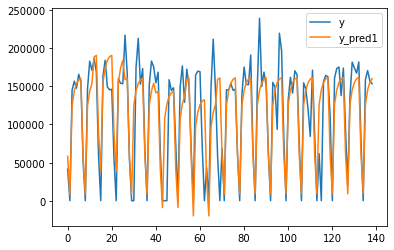

In [22]:
test[["y","y_pred1"]].plot()

<AxesSubplot:>

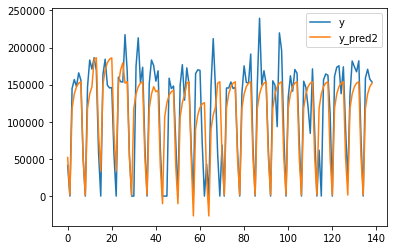

In [23]:
test[["y","y_pred2"]].plot()

<AxesSubplot:xlabel='ds'>

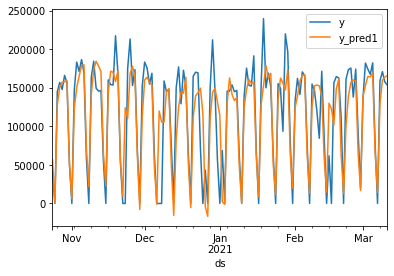

In [24]:
test2[["y","y_pred1"]].plot()

<AxesSubplot:xlabel='ds'>

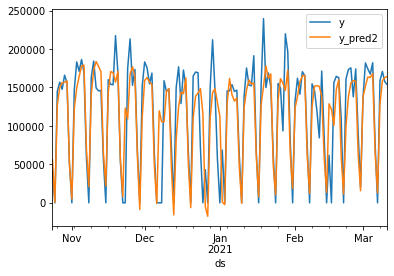

In [25]:
test2[["y","y_pred2"]].plot()

<AxesSubplot:xlabel='ds'>

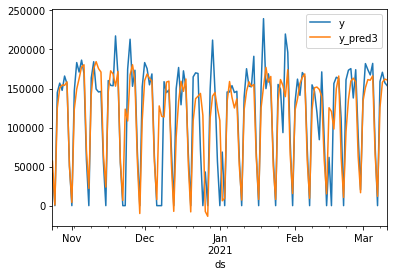

In [26]:
test2[["y","y_pred3"]].plot()

In [27]:
df1=df[df.Tienda==7459]
df1= df1.loc[0:,['Received Date','QTY_received']]
df1=df1.sort_values(['Received Date'], ascending=True)
df1.columns = ['ds', 'y']
df1['ds']= pd.to_datetime(df1['ds'])

df1["Date"] = df1["ds"]
df1.set_index("ds", inplace=True)

bf2 = bf[["ds", "holiday"]]

bf2.set_index("ds", inplace=True)
dummy_holidays = pd.get_dummies(bf2["holiday"], prefix = "holiday")

dummy_holidays.sort_index(inplace=True)
dummy_holidays.head()

df2 = pd.concat([df1, dummy_holidays], axis = 1)

df3 = df2.asfreq("D")

df3.fillna(value = 0, inplace = True)
df3.drop(columns = "Date", inplace = True)

df3["Dia de semana"] = df3.index.day_name()
df3["Media"] = df3["y"].mean()
df3["rolling30"] = df3["y"].rolling(30).mean()

dummy_semana = pd.get_dummies(df3["Dia de semana"])

df4 = pd.concat([df3,dummy_semana], axis = 1)
df4.drop(columns="Monday",inplace=True)
df4.columns = df4.columns.str.replace(" ","")

df4["Dummy_tiempo"] = np.arange(0,len(df4["y"]),1)


train3 = df4["2018-01-23":"2020-10-23"]
test3 = df4["2020-10-24":]

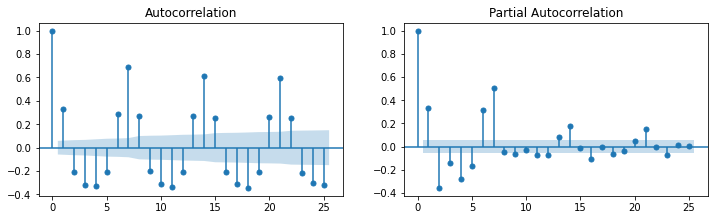

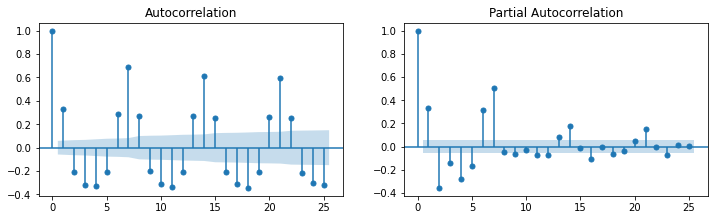

In [28]:
with plt.style.context(style="bmh"):    
        fig = plt.figure(figsize=(12,7))
        layout = (2, 2)

acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))



plot_acf(df4["y"], lags=25, ax=acf_ax)
plot_pacf(df4["y"], lags=25, ax=pacf_ax)

In [29]:
df4["shift1"] = df4["y"].shift(periods=1)
df4["shift2"] = df4["y"].shift(periods=2)
df4["shift3"] = df4["y"].shift(periods=3)
df4["shift4"] = df4["y"].shift(periods=4)
df4["shift5"] = df4["y"].shift(periods=5)
df4["shift6"] = df4["y"].shift(periods=6)
df4["shift7"] = df4["y"].shift(periods=7)

In [30]:
df5= df4.dropna(subset=["shift7"])
df5["Dummy_tiempo"] = np.arange(0,len(df5["y"]),1)

train4 = df5["2018-01-09":"2020-10-23"]
test4 = df5["2020-10-24":]

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

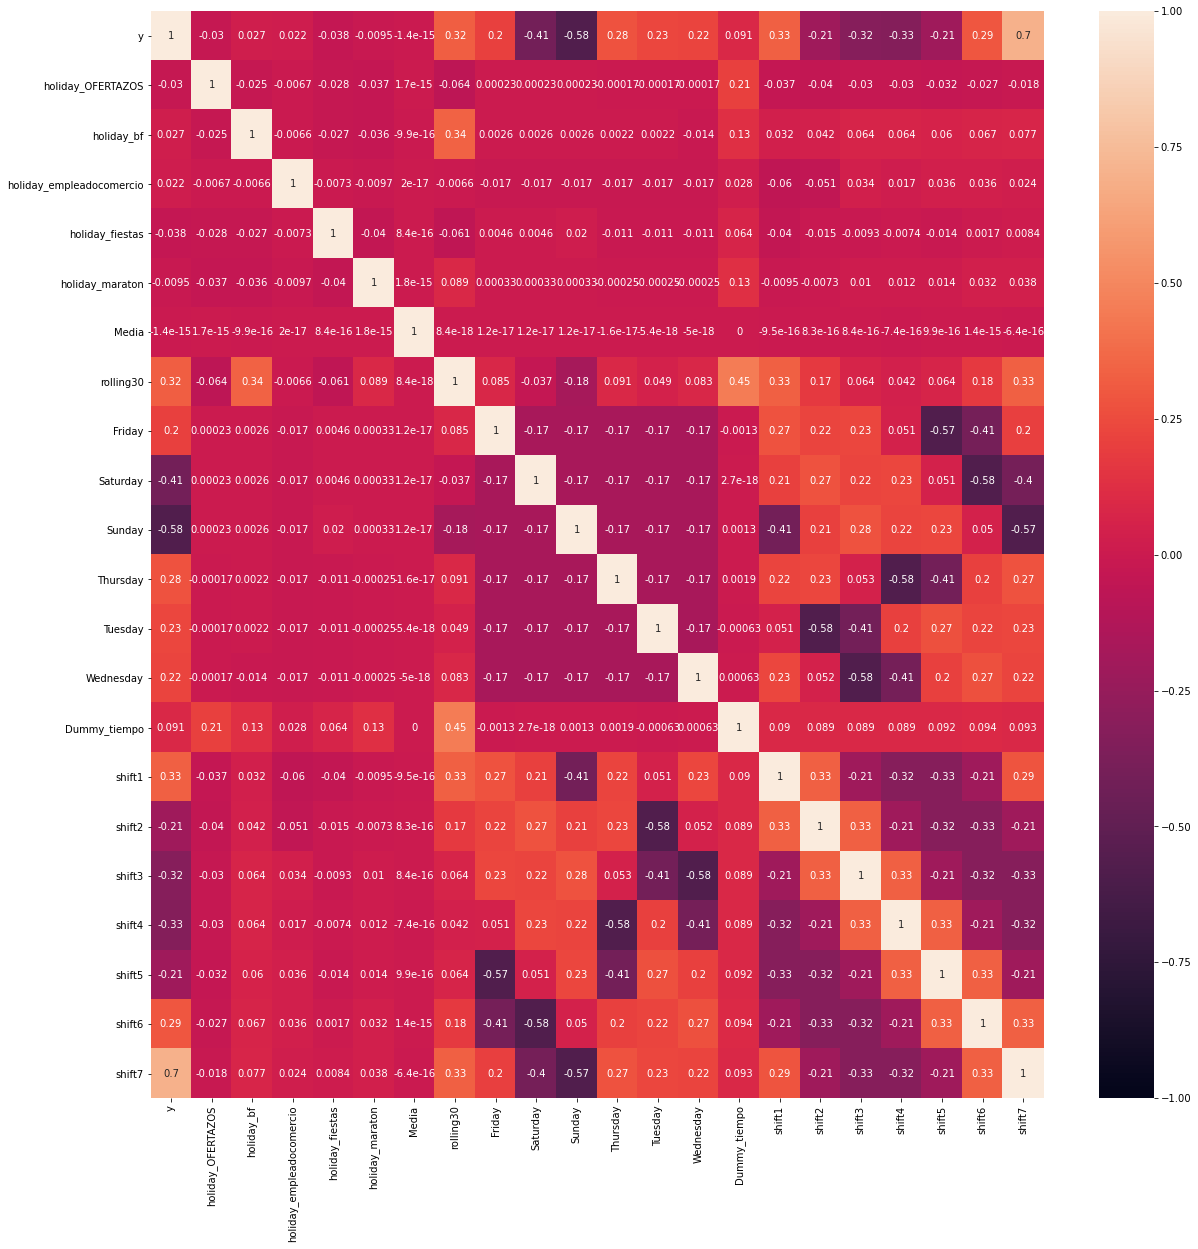

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(df5.corr(), vmin=-1, vmax=1, annot=True)

In [32]:
model_inicial6 = smf.ols('y ~ Dummy_tiempo + holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday',\
                          data = train3).fit()
model_inicial6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     145.7
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          1.67e-197
Time:                        18:41:10   Log-Likelihood:                -11404.
No. Observations:                 992   AIC:                         2.283e+04
Df Residuals:                     980   BIC:                         2.289e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 5.251e+04   2411.900     21.773      0.000    4.78e+04    5.72e+04
Dummy_tiempo                13.5400      2.711      4.995      0.000       8.221      18.859
holiday_OFERTAZOS        -1.643e+04   6564.632     -2.503      0.012   -2.93e+04   -3546.104
holiday_bf                7446.6433   6698.607      1.112      0.267   -5698.621    2.06e+04
holiday_empleadocomercio  1.325e+04   1.71e+04      0.777      0.438   -2.02e+04    4.67e+04
holiday_fiestas          -1.377e+04   5166.750     -2.666      0.008   -2.39e+04   -3635.610
Friday                    1.527e+04   2850.980      5.358      0.000    9679.478    2.09e+04
Saturday                 -4.152e+04   2855.961    -14.536      0.000   -4.71e+04   -3.59e+04
Sunday                   -5.871e+04   2855.977    -20.555      0.000   -6.43e+04   -5.31e+04
Thursday                  2.262e+04   2850.751      7.933      0.000     1.7e+04    2.82e+04
Tuesday                    1.66e+04   2850.974      5.824      0.000     1.1e+04    2.22e+04
Wednesday                  1.61e+04   2851.431      5.648      0.000    1.05e+04    2.17e+04
==============================================================================
Omnibus:                       53.509   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.019
Skew:                          -0.237   Prob(JB):                     1.96e-32
Kurtosis:                       4.819   Cond. No.                     1.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
model_inicial7 = smf.ols('y ~ holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday',\
                          data = train3).fit()
model_inicial7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     154.1
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          2.74e-193
Time:                        18:41:10   Log-Likelihood:                -11416.
No. Observations:                 992   AIC:                         2.285e+04
Df Residuals:                     981   BIC:                         2.291e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 5.902e+04   2055.123     28.716      0.000     5.5e+04     6.3e+04
holiday_OFERTAZOS        -1.018e+04   6522.491     -1.561      0.119    -2.3e+04    2620.687
holiday_bf                9520.8311   6766.844      1.407      0.160   -3758.323    2.28e+04
holiday_empleadocomercio  1.732e+04   1.73e+04      1.004      0.316   -1.65e+04    5.12e+04
holiday_fiestas          -1.351e+04   5229.166     -2.584      0.010   -2.38e+04   -3249.296
Friday                    1.538e+04   2885.486      5.331      0.000    9721.341     2.1e+04
Saturday                 -4.144e+04   2890.574    -14.336      0.000   -4.71e+04   -3.58e+04
Sunday                   -5.862e+04   2890.574    -20.279      0.000   -6.43e+04   -5.29e+04
Thursday                  2.271e+04   2885.272      7.872      0.000    1.71e+04    2.84e+04
Tuesday                   1.668e+04   2885.528      5.780      0.000     1.1e+04    2.23e+04
Wednesday                  1.62e+04   2885.956      5.615      0.000    1.05e+04    2.19e+04
==============================================================================
Omnibus:                       51.947   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.628
Skew:                          -0.256   Prob(JB):                     2.61e-29
Kurtosis:                       4.709   Cond. No.                         23.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
model_inicial8 = smf.ols('y ~ Dummy_tiempo + holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday + shift1 + shift2 + shift3 + shift4 + shift5 + shift6 + shift7',\
                          data = train4).fit()
model_inicial8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     96.51
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          3.28e-201
Time:                        18:41:10   Log-Likelihood:                -11295.
No. Observations:                 985   AIC:                         2.263e+04
Df Residuals:                     966   BIC:                         2.272e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4.268e+04   4751.577      8.981      0.000    3.34e+04     5.2e+04
Dummy_tiempo                 8.2604      2.811      2.939      0.003       2.745      13.776
holiday_OFERTAZOS        -1.124e+04   6489.958     -1.732      0.084    -2.4e+04    1494.106
holiday_bf                1671.7774   6652.370      0.251      0.802   -1.14e+04    1.47e+04
holiday_empleadocomercio  1.058e+04   1.67e+04      0.635      0.526   -2.21e+04    4.33e+04
holiday_fiestas          -1.164e+04   5080.577     -2.291      0.022   -2.16e+04   -1668.503
Friday                    2963.1737   5032.737      0.589      0.556   -6913.185    1.28e+04
Saturday                 -4.405e+04   4806.170     -9.166      0.000   -5.35e+04   -3.46e+04
Sunday                   -5.163e+04   3831.681    -13.473      0.000   -5.91e+04   -4.41e+04
Thursday                  9498.5217   5052.982      1.880      0.060    -417.566    1.94e+04
Tuesday                   7099.9352   3882.809      1.829      0.068    -519.778    1.47e+04
Wednesday                 5376.7645   4905.735      1.096      0.273   -4250.361     1.5e+04
shift1                       0.1465      0.032      4.602      0.000       0.084       0.209
shift2                      -0.0159      0.032     -0.495      0.621      -0.079       0.047
shift3                       0.0386      0.032      1.199      0.231      -0.025       0.102
shift4                      -0.0057      0.032     -0.176      0.860      -0.069       0.057
shift5                       0.0036      0.032      0.113      0.910      -0.059       0.067
shift6                       0.0175      0.032      0.544      0.586      -0.045       0.080
shift7                       0.1547      0.032      4.876      0.000       0.092       0.217
==============================================================================
Omnibus:                       74.150   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.613
Skew:                          -0.374   Prob(JB):                     8.27e-46
Kurtosis:                       5.121   Cond. No.                     3.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
model_inicial9 = smf.ols('y ~ holiday_OFERTAZOS + holiday_bf + holiday_empleadocomercio + holiday_fiestas + Friday + Saturday + Sunday + Thursday + Tuesday + Wednesday + shift1 + shift2 + shift3 + shift4 + shift5 + shift6 + shift7',\
                          data = train4).fit()
model_inicial9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     100.9
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          2.28e-200
Time:                        18:41:10   Log-Likelihood:                -11299.
No. Observations:                 985   AIC:                         2.263e+04
Df Residuals:                     967   BIC:                         2.272e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4.317e+04   4767.356      9.055      0.000    3.38e+04    5.25e+04
holiday_OFERTAZOS        -6865.8888   6341.748     -1.083      0.279   -1.93e+04    5579.287
holiday_bf                1677.3984   6678.590      0.251      0.802   -1.14e+04    1.48e+04
holiday_empleadocomercio  1.265e+04   1.67e+04      0.757      0.449   -2.02e+04    4.55e+04
holiday_fiestas          -1.102e+04   5096.226     -2.162      0.031    -2.1e+04   -1019.375
Friday                    2869.8822   5052.473      0.568      0.570   -7045.194    1.28e+04
Saturday                  -4.41e+04   4825.082     -9.140      0.000   -5.36e+04   -3.46e+04
Sunday                   -5.156e+04   3846.710    -13.402      0.000   -5.91e+04    -4.4e+04
Thursday                  9395.4001   5072.776      1.852      0.064    -559.519    1.94e+04
Tuesday                   7005.9436   3897.981      1.797      0.073    -643.533    1.47e+04
Wednesday                 5248.8136   4924.877      1.066      0.287   -4415.865    1.49e+04
shift1                       0.1570      0.032      4.944      0.000       0.095       0.219
shift2                      -0.0069      0.032     -0.216      0.829      -0.070       0.056
shift3                       0.0472      0.032      1.466      0.143      -0.016       0.110
shift4                       0.0031      0.032      0.097      0.923      -0.060       0.066
shift5                       0.0128      0.032      0.399      0.690      -0.050       0.076
shift6                       0.0263      0.032      0.821      0.412      -0.037       0.089
shift7                       0.1648      0.032      5.204      0.000       0.103       0.227
==============================================================================
Omnibus:                       78.245   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.910
Skew:                          -0.412   Prob(JB):                     1.59e-46
Kurtosis:                       5.112   Cond. No.                     3.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
train3["y_pred1"] = model_inicial6.predict(train[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])
train3["y_pred2"] = model_inicial7.predict(train[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])

test3["y_pred1"] = model_inicial6.predict(test[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])
test3["y_pred2"] = model_inicial7.predict(test[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday"]])

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [37]:
train4["y_pred1"] = model_inicial8.predict(train2[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday", "shift1", "shift2", "shift3","shift4","shift5","shift6","shift7"]])
train4["y_pred2"] = model_inicial9.predict(train2[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1", "shift2", "shift3","shift4","shift5","shift6","shift7"]])

test4["y_pred1"] = model_inicial8.predict(test2[["Dummy_tiempo",\
                                               "holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday", "shift1", "shift2", "shift3","shift4","shift5","shift6","shift7"]])
test4["y_pred2"] = model_inicial9.predict(test2[["holiday_OFERTAZOS", "holiday_bf","holiday_empleadocomercio", "holiday_fiestas",\
                                               "Friday","Saturday","Sunday","Thursday", "Tuesday","Wednesday","shift1", "shift2", "shift3","shift4","shift5","shift6","shift7"]])


C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t0z006t\Anaconda3\envs\dhblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

<AxesSubplot:xlabel='ds'>

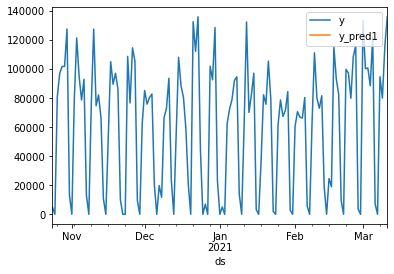

In [38]:
test3[["y","y_pred1"]].plot()

<AxesSubplot:xlabel='ds'>

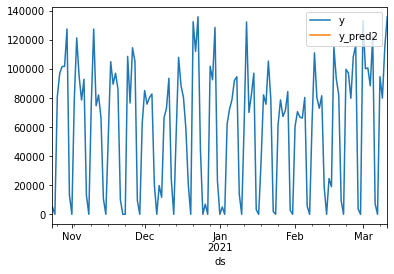

In [39]:
test3[["y","y_pred2"]].plot()

<AxesSubplot:xlabel='ds'>

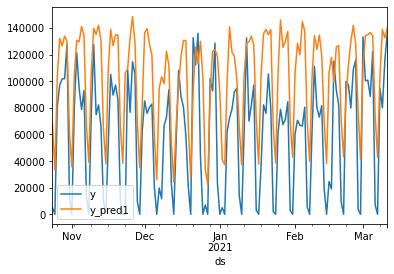

In [40]:
test4[["y","y_pred1"]].plot()

<AxesSubplot:xlabel='ds'>

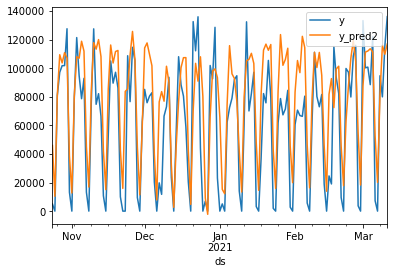

In [41]:
test4[["y","y_pred2"]].plot()

In [43]:
#visualizamos la serie de tiempos real de cada CD
import plotly.graph_objects as go
data_7460=df[df.Tienda==7460]
strt='2018-02-01'
data_7460=data_7460[(data_7460['Received Date']>strt)]
      
data_7460_graf= data_7460.loc[0:,['Received Date','QTY_received']]
data_7460_graf=data_7460_graf.sort_values(['Received Date'], ascending=True)
salmon_value = go.Figure()

salmon_value.add_trace(go.Scatter(x=data_7460_graf['Received Date'], y=data_7460_graf['QTY_received'],
                             mode='lines',
                             name='real_sales'))


salmon_value.show()

In [44]:
data_7459=df[df.Tienda==7459]
strt='2018-02-01'
data_7459=data_7459[(data_7459['Received Date']>strt)]
      
data_7459_graf= data_7459.loc[0:,['Received Date','QTY_received']]
data_7459_graf=data_7459_graf.sort_values(['Received Date'], ascending=True)
salmon_value = go.Figure()

salmon_value.add_trace(go.Scatter(x=data_7459_graf['Received Date'], y=data_7459_graf['QTY_received'],
                             mode='lines',
                             name='real_sales'))


salmon_value.show()

In [45]:
#Unimos info de ambos cds en un mismo dataset

df = pd.concat([data_7460, data_7459])

In [46]:
#Entrenamos el modelo FBProphet para cada CD con GridSearch, Tomamos el que mejor resultado nos da y luego guardamos el modelo serializado en pickle.
Cds = df.Tienda.unique()
for i in Cds: 
    df1=df[df.Tienda==i]
    df1= df1.loc[0:,['Received Date','QTY_received']]
    df1=df1.sort_values(['Received Date'], ascending=True)
    df1.columns = ['ds', 'y']
    df1['ds']= pd.to_datetime(df1['ds'])
    train = df1.drop(df1.index[-100:])
    test = df1.iloc[-100:]
    test =pd.DataFrame(test["ds"])
    test1 =pd.DataFrame(test["ds"])
    #parameter Tunning
    from sklearn.model_selection import ParameterGrid
    params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.03,0.05,0.1,0.2,0.3,0.4],
              'holidays_prior_scale':[0.003,0.005,0.01],
              'n_changepoints' : [15,25,50,75,100,125]}
    grid = ParameterGrid(params_grid)
    cnt = 0
    for p in grid:
        cnt = cnt+1

    print('Total Possible Models',cnt)
    strt='2019-12-31'
    end='2020-02-26'

    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        print(p)
   
        train_model=Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=bf, 
                         interval_width=0.95)
    #train_model.add_country_holidays(country_name='US')
        train_model.fit(train)
    #train_forecast = train_model.make_future_dataframe(periods=56, freq='D',include_history = False)
        train_forecast = train_model.predict(test1)
        test1=train_forecast[['ds','yhat']]
        
        
    #Actual = df[(df['ds']>strt) & (df['ds']<=end)]
        y_true = df1['y'][-100:].values
        y_pred = test1['yhat'].values
        MAPE = mean_absolute_percentage_error(y_true,abs(y_pred))
    
        print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
        model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    dic=parameters['Parameters'][0]
    print(dic)
    parameters.loc[0:0]
    a="{}".format(i)+'.pkl'
    b="{}".format(i)
    with open(a, 'wb') as b:
        pickle.dump(Prophet(holidays=bf,**dic,weekly_seasonality=True,daily_seasonality = True,yearly_seasonality = True,
                      interval_width=0.95), b)

Total Possible Models 216
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.003, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.048000703089528
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.003, 'n_changepoints': 15, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.30570237365003
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.003, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.2079256372335
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.003, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.182662915944448
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.003, 'n_changepoints': 50, 'seasonality_mode': 'multiplicativ

Mean Absolute Percentage Error(MAPE)------------------------------------ 25.581854027169708
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.003, 'n_changepoints': 25, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.844621323028356
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.003, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.47351351154142
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.003, 'n_changepoints': 50, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.099667783818752
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.003, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.39895458667314
{'changepoint_prior_scale': 0.05, 'holidays_prior_scal

KeyboardInterrupt: 

In [ ]:
#Apelamos a cada objeto guardado para predecir los datos desconocidos del modelo para evaluar las metricas finales y el comportamiento de lo predecido vs lo real. 

for i in Cds: 
    b="{}".format(i)
    with open(b+'.pkl', 'rb') as a:
        modelo = pickle.load(a)
    df1=df[df.Tienda==i]
    df2= df1.loc[0:,['Received Date','QTY_received']]
    df2=df2.sort_values(['Received Date'], ascending=True)
    df2.columns = ['ds', 'y']
    train = df2.drop(df2.index[-100:])
    modelo.fit(train)
    test = df2.iloc[-100:]
    forecast=modelo.predict(test)
    y_true = df2['y'][-100:].values
    y_total=df2[:].values
    y_pred = forecast['yhat'].values
    print('Mean Absolute Percentage Error(MAPE)--',round(mean_absolute_percentage_error(y_true,y_pred),2))
    print('Median Absolute Percentage Error(MAPE)--',round(median_absolute_percentage_error(y_true,y_pred),2))
    print('Simetric Median Absolute Percentage Error(SMAPE)--',round(smape(y_true,y_pred),2))
    comparison= pd.merge(df2, forecast, on='ds')
    comparison=comparison.loc[:,["ds","y","yhat"]]
    salmon_value = go.Figure()
    
    salmon_value.add_trace(go.Scatter(x=comparison.ds, y=comparison.y,
                             mode='lines',
                             name='y_true'))
    salmon_value.add_trace(go.Scatter(x=comparison.ds, y=comparison.yhat,
                             mode='lines+markers',
                             name='y_pred'))


    salmon_value.show()
